In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import imageio
import torch
import torchvision
from skimage.transform import resize
import json
from transforms3d.conversions import rad2deg

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def plot_img_tensor(img, nrow=4):
    """Helper function to plot image tensors.
    
    Args:
        img (torch.Tensor): Image or batch of images of shape 
            (batch_size, channels, height, width).
    """
    img_grid = torchvision.utils.make_grid(img, nrow=nrow)
    plt.imshow(img_grid.cpu().numpy().transpose(1, 2, 0))

# Equivariant Neural Rendering

This notebook contains examples of how to load a trained Equivariant Neural Renderer and use it to infer scene representations from a single image, as well as rendering novel views of the scene.

## Load trained model

In [3]:
from models.neural_renderer import load_model

# Load trained chairs model
model = load_model('trained-models/chairs.pt').to(device)

## Load image

(64, 64, 3)


/scratch/ipykernel_27286/1985998985.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img_source = imageio.imread(f'{path}/{source_id}.png')[:, :, :3]
/scratch/ipykernel_27286/1985998985.py:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img_target= imageio.imread(f'{path}/{target_id}.png')[:, :, :3]


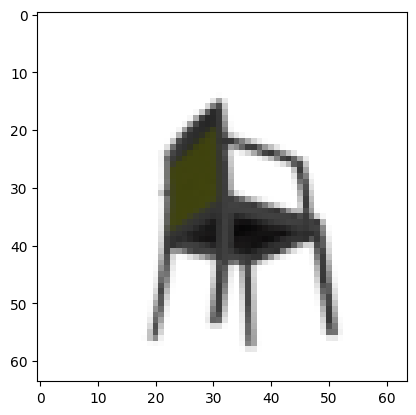

(64, 64, 3)
(64, 64, 3)


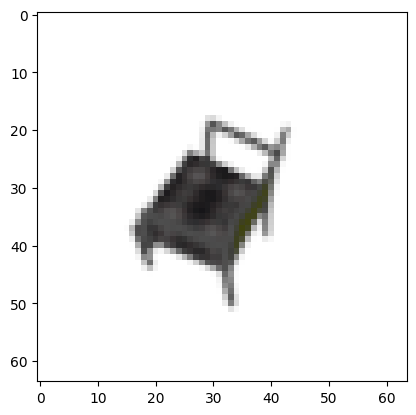

(64, 64, 3)


In [33]:
source_id, target_id = '00001', '00005'
# img_source = imageio.imread('imgs/example-data/chair4.png')
path = '/project/gpuuva022/shared/equiv-neural-rendering/chairs/data_all/rot_dataset/1a6f615e8b1b5ae4dbbc9440457e303e'
path = '/project/gpuuva022/shared/equiv-neural-rendering/chairs/data_half/rot_dataset/rest/1a6f615e8b1b5ae4dbbc9440457e303e'
CONVERT2DEGREES = True

img_source = imageio.imread(f'{path}/{source_id}.png')[:, :, :3]
img_target= imageio.imread(f'{path}/{target_id}.png')[:, :, :3]

for img in [img_source, img_target]:

    # You can also try loading other examples (e.g. 'chair1.png')
    # Visualize image
    print(img.shape)
    # img = img[:, :, :3]
    plt.imshow(img)
    plt.show()
    print(img.shape)

## Infer and render scene representation

In [34]:
from torchvision.transforms import ToTensor

# Convert image to tensor and add batch dimension
img_source = ToTensor()(img_source)
img_source = img_source.unsqueeze(0).to(device)

# Infer scene representation
scene = model.inverse_render(img_source)

# Print scene shape
print("Scene shape: {}".format(scene.shape))

RuntimeError: shape '[1, 32, 32, 32, 32]' is invalid for input of size 262144

: 

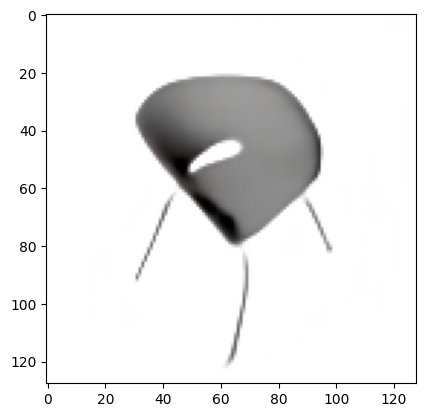

In [16]:
# We can render the scene representation without rotating it
rendered = model.render(scene)

plot_img_tensor(rendered.detach())

org = rendered.detach().clone()

## Generate novel views

In [17]:
# # Initialize a rotation matrix
# rotation_matrix = torch.Tensor(
#    [[[ 0.4198, -0.3450, -0.8395, 0.0000],
#      [-0.2159,  0.8605, -0.4615, 10.000],
#      [ 0.8816,  0.3749,  0.2867, 10.0000],
#      [ 0.0000,  0.0000,  0.0000, 1.0000]]]
# ).to(device)

# rotation_matrix = torch.Tensor(
#    [[[ 1.0000,  10.0000,  10.0000,  1.0000],
#      [ 0.0000,  1.0000,  0.0000,  2.000],
#      [ 0.5000,  0.0000,  1.0000,  3.0000],
#      [ 0.0000,  0.0000,  0.0000,  1.0000]]]
# ).to(device)
# This does not work as intended

# # Rotate scene by rotation matrix
# rotated_scene = model.rotate(scene, rotation_matrix)

# # Render rotated scene
# rendered = model.render(rotated_scene)

# plot_img_tensor(rendered.detach())

In [18]:
# read the json file data_prep/output/rot_dataset/model.dae/render_params.json
with open(f'{path}/render_params.json') as f:
    data = json.load(f)
    print(data)

{'00000': {'azimuth': 33.64900549324327, 'elevation': 41.901958128931945}, '00001': {'azimuth': 311.0172266502673, 'elevation': 40.46410085580671}, '00002': {'azimuth': 188.75215841236297, 'elevation': -7.187465209595942}, '00003': {'azimuth': 96.83440590120881, 'elevation': 17.88842002613613}, '00004': {'azimuth': 268.1057128311105, 'elevation': 26.039397026900104}, '00005': {'azimuth': 53.41236276235027, 'elevation': 19.750978461852768}, '00006': {'azimuth': 55.09087492069173, 'elevation': 30.479907912000492}, '00007': {'azimuth': 277.50892988411545, 'elevation': -47.029632034626985}, '00008': {'azimuth': 95.96676014075292, 'elevation': 10.612035088213958}, '00009': {'azimuth': 256.93853795324725, 'elevation': -27.48978587591948}, '00010': {'azimuth': 214.3209988910624, 'elevation': -31.004819788861482}, '00011': {'azimuth': 257.88770202144724, 'elevation': 14.867481997752861}, '00012': {'azimuth': 150.78384351347012, 'elevation': 9.114454640986139}, '00013': {'azimuth': 118.66097207

In [30]:
# As a rotation matrix can feel a little abstract, we can also reason in terms of 
# camera azimuth and elevation. The initial coordinate at which the source image
# is observed is given by the following azimuth and elevation. Note that these
# are not necessary to generate novel views (as shown above), we just use them 
# for convenience to generate rotation matrices
# azimuth_source = torch.Tensor([42.561195]).to(device)
# elevation_source = torch.Tensor([23.039995]).to(device)
# translations_source = torch.Tensor([0., 0., 0.]).to(device)

def read_coords(img_id, data, convert2degrees = CONVERT2DEGREES):
    if convert2degrees:
        azimuth_source = rad2deg(torch.Tensor([data[img_id]['azimuth']])).to(device)
        elevation_source = rad2deg(torch.Tensor([data[img_id]['elevation']])).to(device)
    else:
        azimuth_source = torch.Tensor([data[img_id]['azimuth']]).to(device)
        elevation_source = torch.Tensor([data[img_id]['elevation']]).to(device)

    translations_source = torch.Tensor([data[img_id].get('x', 0), data[img_id].get('y', 0), data[img_id].get('z', 0)]).to(device)
    return azimuth_source, elevation_source, translations_source

azimuth_source, elevation_source, translations_source = read_coords(source_id)
print(azimuth_source, elevation_source, translations_source )

tensor([311.0172]) tensor([40.4641]) tensor([0., 0., 0.])


tensor([53.4124]) tensor([19.7510]) tensor([0., 0., 0.])


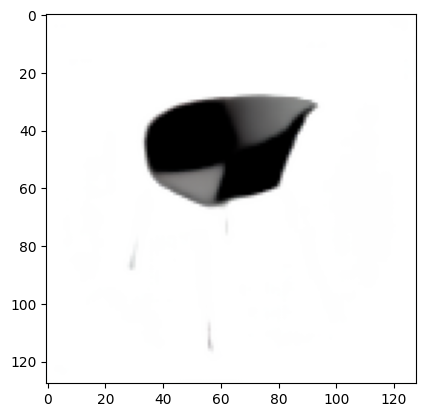

In [31]:
# for i in [0, 0.1, 0.3, 0.5]:
for i in [0]:
    # You can set these to any value you like!
    # Positive (negative) values correspond to moving camera to the right (left)
    # azimuth_shift = torch.Tensor([0.]).to(device)  
    # azimuth_shift = -azimuth_source + 0 + 90
    # # Positive (negative) values correspond to moving camera up (down)
    # elevation_shift = torch.Tensor([0.]).to(device)
    # elevation_shift = -elevation_source + 0 
    # # Translation values
    # translations_shift = torch.Tensor([-i, 0, 0]).to(device)

    # azimuth_shift, elevation_shift, translations_shift = read_coords(shift_id)
    # print(azimuth_shift, elevation_shift, translations_shift)


    # azimuth_target = azimuth_source + azimuth_shift
    # elevation_target = elevation_source + elevation_shift
    # translations_target = translations_source + translations_shift

    # print the target coordinates
    azimuth_target, elevation_target, translations_target = read_coords(target_id)
    print(azimuth_target, elevation_target, translations_target)

    # Rotate scene to match target camera angle
    rotated_scene = model.rotate_source_to_target(
        scene, 
        azimuth_source, elevation_source, translations_source,
        azimuth_target, elevation_target, translations_target
    )

    # Render rotated scene
    rendered = model.render(rotated_scene)

    plot_img_tensor(rendered.detach())
    plt.show()

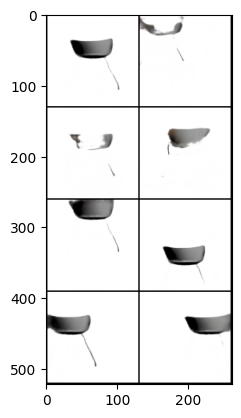

In [32]:
from misc.viz import generate_novel_views

# We can also generate several novel views of the same object
azimuth_shifts = torch.Tensor([20., -50., 120., 180., -90., 50.]).to(device)
elevation_shifts = torch.Tensor([10., -30., 40., -70., 10., 30.]).to(device)

azimuth_shifts = torch.Tensor([20., -50., 120., 180., -90., 50.]).to(device)
elevation_shifts = torch.Tensor([10., -30., 40., -70., 10., 30.]).to(device)




translations_shifts = torch.Tensor([
    [0., 0., 0.],
    [0.5, 0.5, 0.5],
    [0.5, 0., 0.],
    [-0.5, 0., 0.],
    [0., 0.5, 0.],
    [0., -0.5, 0.],
    [0., 0., 0.5],
    [0., 0., -0.5],
]).to(device)

azimuth_shifts   = torch.zeros(len(translations_shifts)).to(device) - azimuth_source
elevation_shifts = torch.zeros(len(translations_shifts)).to(device) - elevation_source

# This function expects a single image as input, so remove batch dimension
views = generate_novel_views(model, img_source[0], 
                             azimuth_source, elevation_source, translations_source,
                             azimuth_shifts, elevation_shifts, translations_shifts)

plot_img_tensor(views.detach(), nrow=2)

## Generate novel view animation

In [ ]:
from misc.utils import full_rotation_angle_sequence, sine_squared_angle_sequence, back_and_forth_angle_sequence
from misc.viz import batch_generate_novel_views, save_img_sequence_as_gif

# num_frames = 25
# azimuth_shifts = full_rotation_angle_sequence(num_frames).to(device)
# elevation_shifts = sine_squared_angle_sequence(num_frames, -10., 20.).to(device)

back_and_forth = back_and_forth_angle_sequence(10, 0, .5)
zeros = torch.zeros(len(back_and_forth))

translations_shifts = torch.stack((
    torch.cat((back_and_forth, zeros, zeros), dim = 0),
    torch.cat((zeros, back_and_forth, zeros), dim = 0),
    torch.cat((zeros, zeros, back_and_forth), dim = 0),
), dim = 1).to(device)

azimuth_shifts   = torch.zeros(len(translations_shifts)).to(device)
elevation_shifts = torch.zeros(len(translations_shifts)).to(device)




# views = batch_generate_novel_views(model, img_source, 
#                                    azimuth_source, elevation_source, translations_source,
#                                    azimuth_shifts, elevation_shifts, translations_shifts)

# # Save generated gif (this gif will display in the next cell once it has been saved)
# save_img_sequence_as_gif(views, 'imgs/novel_views_example.gif')

![chairs-gif](./novel_views_example.gif "chairs-gif")


# Workbench

In [ ]:
path = 'data_prep/output/test/test_ay=02.dae'
path = 'data_prep/output/test/testax=02.dae'
path = 'data_prep/output/test/testaz=02.dae'
path = 'data_prep/output/trans_dataset/model.dae'
path = 'data_prep/output/rot_dataset/model.dae'

# read the json file data_prep/output/rot_dataset/model.dae/render_params.json
with open(f'{path}/render_params.json') as f:
    data = json.load(f)
    print(data)

FileNotFoundError: [Errno 2] No such file or directory: 'data_prep/output/rot_dataset/model.dae/render_params.json'

/scratch/ipykernel_12472/1985035621.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(f'{path}/{img_id:05d}.png')[:, :, :3]


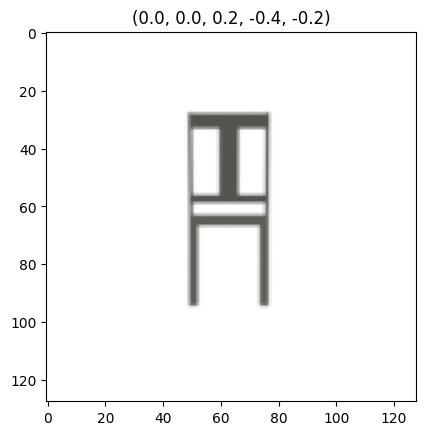

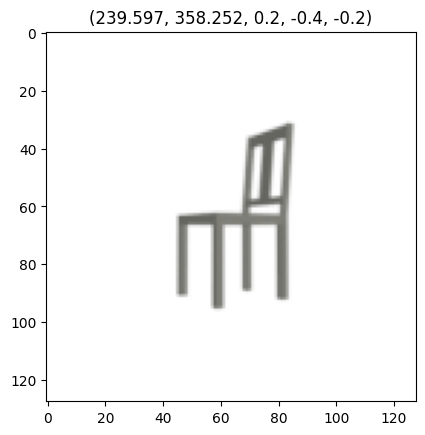

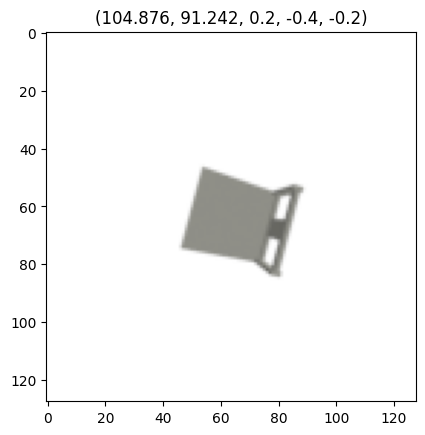

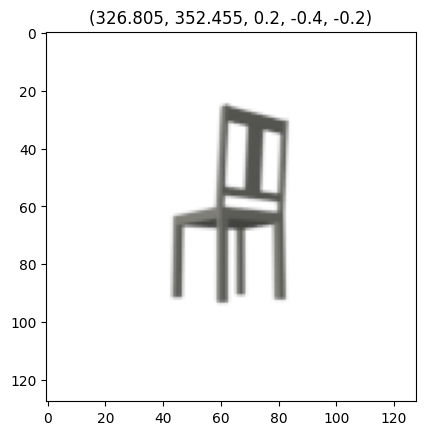

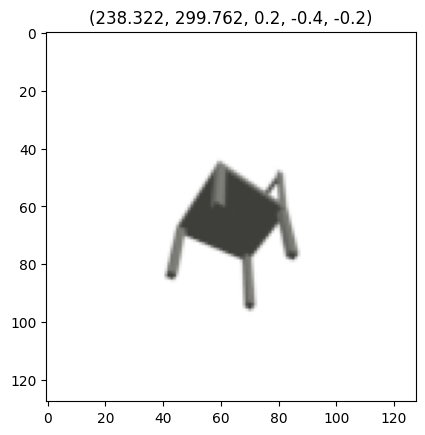

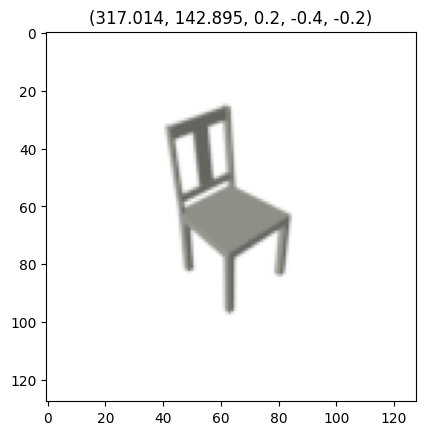

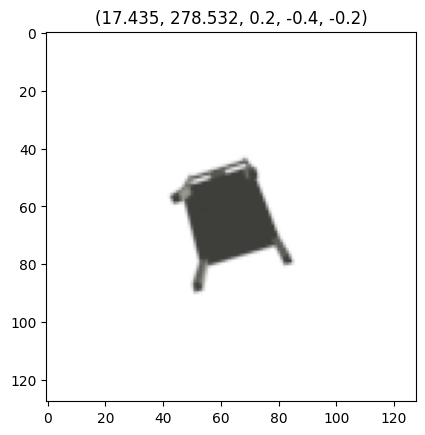

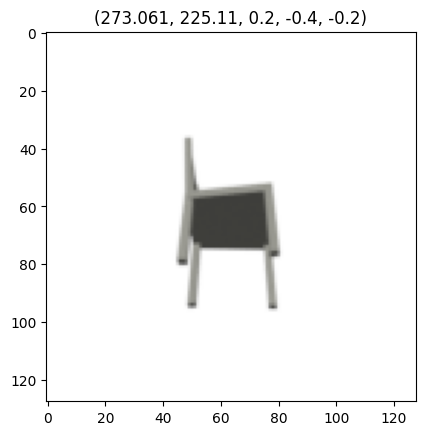

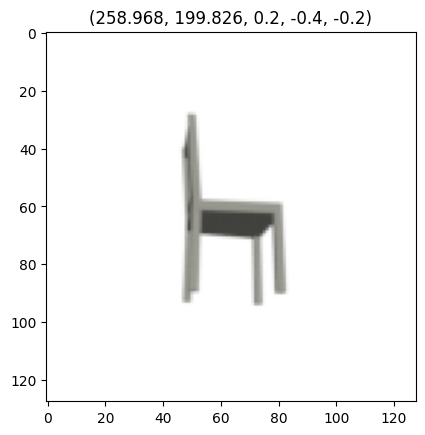

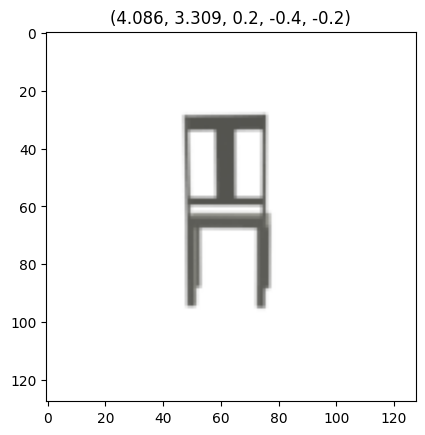

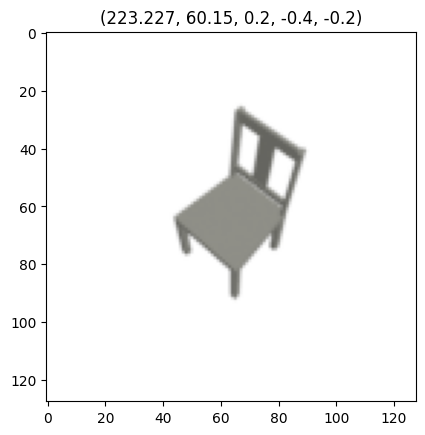

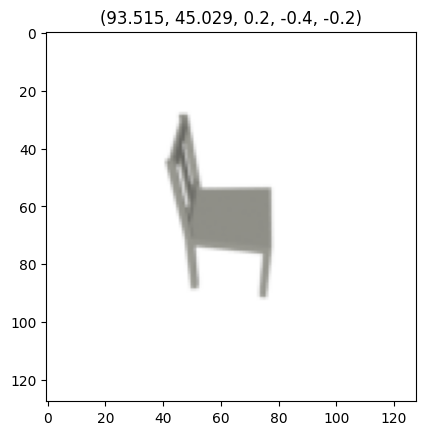

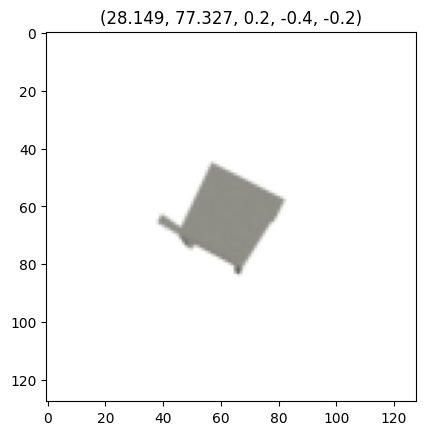

KeyboardInterrupt: 

In [ ]:
for img_id in range(0, 50):

    img = imageio.imread(f'{path}/{img_id:05d}.png')[:, :, :3]

    coords = \
        round(rad2deg(data[f'{img_id:05d}']['azimuth']), 3), \
        round(rad2deg(data[f'{img_id:05d}']['elevation']), 3) , \
        round(data[f'{img_id:05d}']['x'], 3), round(data[f'{img_id:05d}']['y'], 3), round(data[f'{img_id:05d}']['z'], 3)

    plt.imshow(img)
    plt.title(coords)
    plt.show()
    
